In [23]:
import os 
from pathlib import Path
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd

## AD/CN data

In [24]:
def get_data(path):
    data = pd.read_csv(path, names= ['Subject ID', 'Rooster ID', 'Age', 'Sexe', 'Group', 'Conversion', 'MMSE', 'RAVLT', 'FAQ', 'CDR-SB', 'ADAS11'], usecols = ['Subject ID', 'Rooster ID', 'Group'])
    data.index = data['Subject ID']
    data = data.drop(['Subject ID'], axis=1)
    data = data[((data.Group == 'AD') | (data.Group == 'CN'))]
    return data


## Sagital/Coronal/Axial slices

In [80]:
def sagital_adjacent_slices(img_n_mmni, m, epsilon, y_tuple, z_tuple):
    crop_img = img_n_mmni.slicer[m-epsilon:m+epsilon+1:epsilon, y_tuple[0]:y_tuple[1], z_tuple[0]:z_tuple[1]]
    crop_img = crop_img.get_fdata()
    crop_img = np.transpose(crop_img, (1, 2, 0))
    return crop_img

def coronal_adjacent_slices(img_n_mmni, x_tuple, m, epsilon, z_tuple):
    crop_img = img_n_mmni.slicer[x_tuple[0]:x_tuple[1], m-epsilon:m+epsilon+1:epsilon, z_tuple[0]:z_tuple[1]]
    crop_img = crop_img.get_fdata()
    crop_img = np.transpose(crop_img, (0, 2, 1))
    return crop_img

def axial_adjacent_slices(img_n_mmni, x_tuple, y_tuple, m, epsilon):
    crop_img = img_n_mmni.slicer[x_tuple[0]:x_tuple[1], y_tuple[0]:y_tuple[1], m-epsilon:m+epsilon+1:epsilon]
    return crop_img.get_fdata()


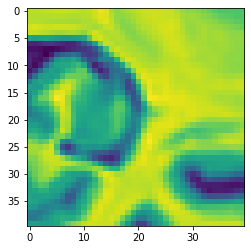

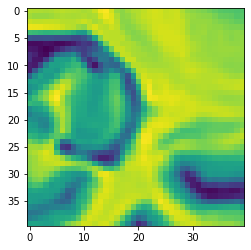

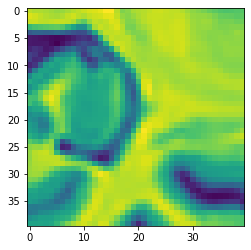

In [82]:
# get an image n_mmni
path = str(Path().resolve())
path = path + "/ADNI1/"
filename = os.listdir(path)[2]
n_mmni_filename = os.path.join(path, filename)
img_n_mmni = nib.load(n_mmni_filename)

#Test of coronal projection
img_data = coronal_adjacent_slices(img_n_mmni, (40,80), 110, 1,(40,80))

img_data = coronal_adjacent_slices(img_n_mmni, (100,140), 110, 1,(40,80))


for i in range(3):
    plt.imshow(img_data[:, :, i])
    plt.show()

In [27]:
path = str(Path().resolve()) + "/ADNI1/list_standardized_tongtong_2017.csv"
y_data = get_data(path)
y_data.head(7)


,Rooster ID,Group
Subject ID,,
002_S_0295,295,CN
002_S_0413,413,CN
002_S_0559,559,CN
002_S_0619,619,AD
002_S_0685,685,CN
002_S_0816,816,AD
002_S_0938,938,AD


In [28]:
print(y_data.shape)

(420, 2)


## Dataset preparation (with Data augmentation)

In [29]:
from tensorflow.keras.utils import to_categorical


def Data_preparation(Y, epsilon=1):
    X_data = []
    Y_data = []
    
    path = str(Path().resolve()) + "/ADNI1"
    for index, _ in Y.iterrows():
        filename = path + '/n_mmni_fADNI_' + index + '_1.5T_t1w.nii.gz'
        
        if os.path.isfile(filename):
            img_n_mmni = nib.load(filename)
        
            for i in range(-2,1):
                img_3_projections = []
                img_slices_data = sagital_adjacent_slices(img_n_mmni, 60+i, epsilon, (90+i,130+i), (30+i,70+i))
                img_3_projections.append(img_slices_data)

                img_slices_data = coronal_adjacent_slices(img_n_mmni, (40+i,80+i), 110+i, epsilon, (30+i,70+i))
                img_3_projections.append(img_slices_data)

                img_slices_data = axial_adjacent_slices(img_n_mmni, (40+i,80+i), (90+i,130+i), 60+i, epsilon)
                img_3_projections.append(img_slices_data)

                img_3_projections = np.array(img_3_projections)
                X_data.append(img_3_projections)

                if Y['Group'][index] == 'AD':
                    Y_data.append(1)
                elif Y['Group'][index] == 'CN':
                    Y_data.append(0)

            for i in range(-2,1):
                img_3_projections = []

                img_slices_data = sagital_adjacent_slices(img_n_mmni, 120+i, epsilon, (90+i,130+i), (30+i,70+i))
                img_slices_data = img_slices_data[:, :, ::-1]
                img_3_projections.append(img_slices_data)

                img_slices_data = coronal_adjacent_slices(img_n_mmni, (100+i,140+i), 110+i, epsilon, (30+i,70+i))
                img_slices_data = img_slices_data[::-1, :, :]
                img_3_projections.append(img_slices_data)

                img_slices_data = axial_adjacent_slices(img_n_mmni,(100+i,140+i), (90+i,130+i), 60+i, epsilon)
                img_slices_data = img_slices_data[::-1, :, :]
                img_3_projections.append(img_slices_data)

                img_3_projections = np.array(img_3_projections)
                X_data.append(img_3_projections)

                if Y['Group'][index] == 'AD':
                    Y_data.append(1)
                elif Y['Group'][index] == 'CN':
                    Y_data.append(0)
        
    X_data = np.array(X_data)   
    return X_data, Y_data


In [30]:
X_data, Y_data = Data_preparation(y_data, 1) #epsilon=1
Y_data = to_categorical(Y_data, num_classes=2)

print(X_data.shape)
print(len(Y_data))

(2514, 3, 40, 40, 3)
2514


## Split Dataset 80% train (AD/CN) , 20%Test (AD/CN)

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=49) 

print("len(X_train) = ", len(X_train))
print("len(X_test) = ", len(X_test))

len(X_train) =  2011
len(X_test) =  503


## Network

In [32]:
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, UpSampling2D, Cropping2D, Conv3D, MaxPooling3D, UpSampling3D, Cropping3D, Input, Concatenate, Flatten, Dense, Dropout, BatchNormalization, Activation, BatchNormalization, GlobalAveragePooling2D, GlobalAveragePooling3D, add
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


def Slices_network(inputs, i, padding='same'):
    x = inputs[:,i,:,:]
    num_filters = 32

    x = SeparableConv2D(filters=num_filters, kernel_size=(4,4), strides=1, padding=padding)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3,3), strides=2)(x)
    x = Activation('relu')(x)
    
    num_filters *= 2
    x = SeparableConv2D(filters=num_filters, kernel_size=(2,2), strides=1)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2), strides=2)(x)
    x = Activation('relu')(x)
    
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    return x

def create_model_2D_epsilon(input_size, padding='same', nb_class=2):
    inputs = Input(shape=input_size)
    nb_slices = inputs.shape[1]
    out_list = []
    for i in range(nb_slices):
        out_list.append(Slices_network(inputs=inputs, i=i, padding='same'))

    x = Concatenate(name = "Concat1")(out_list)
    x = Flatten(name = "Flatten1")(x)
    
    outputs = Dense(nb_class, activation='softmax')(x)
    
    return Model(inputs, outputs)

    
model = create_model_2D_epsilon(X_train[0].shape)
model.summary()
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
     

    

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 3, 40, 40,   0           []                               
                                3)]                                                               
                                                                                                  
 tf.__operators__.getitem_3 (Sl  (None, 40, 40, 3)   0           ['input_2[0][0]']                
 icingOpLambda)                                                                                   
                                                                                                  
 tf.__operators__.getitem_4 (Sl  (None, 40, 40, 3)   0           ['input_2[0][0]']                
 icingOpLambda)                                                                             

 flatten_3 (Flatten)            (None, 5184)         0           ['dropout_3[0][0]']              
                                                                                                  
 flatten_4 (Flatten)            (None, 5184)         0           ['dropout_4[0][0]']              
                                                                                                  
 flatten_5 (Flatten)            (None, 5184)         0           ['dropout_5[0][0]']              
                                                                                                  
 Concat1 (Concatenate)          (None, 15552)        0           ['flatten_3[0][0]',              
                                                                  'flatten_4[0][0]',              
                                                                  'flatten_5[0][0]']              
                                                                                                  
 Flatten1 

In [33]:
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, verbose=1, restore_best_weights=True)
history = model.fit(X_train, Y_train, epochs=40, validation_data=(X_test, Y_test), callbacks=[callback])

2022-12-19 00:13:57.382881: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 115833600 exceeds 10% of free system memory.


Epoch 1/40
63/63 [==============================] - 15s 164ms/step - loss: 0.6480 - accuracy: 0.6733 - val_loss: 0.6554 - val_accuracy: 0.5905
Epoch 2/40
63/63 [==============================] - 10s 158ms/step - loss: 0.5111 - accuracy: 0.7882 - val_loss: 0.5898 - val_accuracy: 0.7634
Epoch 3/40
63/63 [==============================] - 10s 151ms/step - loss: 0.4756 - accuracy: 0.7926 - val_loss: 0.5464 - val_accuracy: 0.7674
Epoch 4/40
63/63 [==============================] - 10s 159ms/step - loss: 0.4532 - accuracy: 0.8046 - val_loss: 0.4850 - val_accuracy: 0.7813
Epoch 5/40
63/63 [==============================] - 10s 161ms/step - loss: 0.4083 - accuracy: 0.8230 - val_loss: 0.4541 - val_accuracy: 0.8072
Epoch 6/40
63/63 [==============================] - 10s 153ms/step - loss: 0.3813 - accuracy: 0.8463 - val_loss: 0.4241 - val_accuracy: 0.8171
Epoch 7/40
63/63 [==============================] - 9s 149ms/step - loss: 0.3701 - accuracy: 0.8463 - val_loss: 0.4126 - val_accuracy: 0.7972


In [53]:
def plot_loss_curves(history):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    nb_epochs = range(len(history.history['loss']))

    plt.plot(nb_epochs, loss, label='train_loss')
    plt.plot(nb_epochs, val_loss, label='val_loss')
    plt.title("loss")
    plt.xlabel("epochs")
    plt.legend()

    plt.figure()
    plt.plot(nb_epochs, acc, label='train_accuracy')
    plt.plot(nb_epochs, val_acc, label='val_accuracy')
    plt.title('accuracy')
    plt.xlabel('epochs')
    plt.legend()

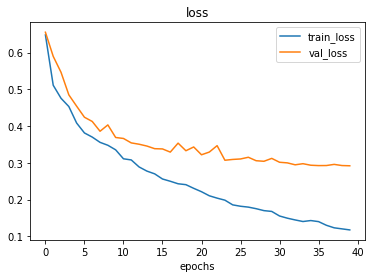

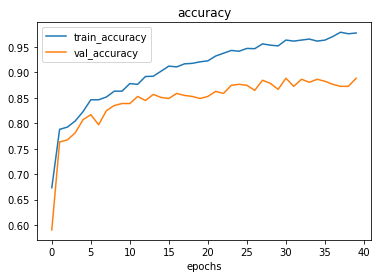

In [54]:
# plot accuarcy and loss 
plot_loss_curves(history)

In [68]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns

pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)

labels = np.argmax(Y_test, axis=1)

16/16 [==============================] - 1s 37ms/step


matrix_confusion of AD/CN :
[[262  28]
 [ 28 185]]


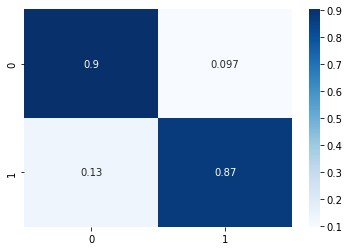

In [83]:
cf_matrix = confusion_matrix(labels, pred)
print("matrix_confusion of AD/CN :")
print(cf_matrix)
cf_matrix = [cf_matrix[0,:]/np.sum(cf_matrix[0,:]), cf_matrix[1,:]/np.sum(cf_matrix[1,:])]
ax = sns.heatmap(cf_matrix, annot=True, 
            fmt='.2', cmap='Blues')
plt.show()


## Training with 80% of AD/CN data for MCI 


In [36]:
def get_data_MCI(path):
    data = pd.read_csv(path, names= ['Subject ID', 'Rooster ID', 'Age', 'Sexe', 'Group', 'Conversion', 'MMSE', 'RAVLT', 'FAQ', 'CDR-SB', 'ADAS11'], usecols = ['Subject ID', 'Rooster ID', 'Group','Conversion'])
    data.index = data['Subject ID']
    data = data.drop(['Subject ID'], axis=1)
    data = data[((data['Conversion'] == 1) | (data['Conversion'] == 2) | (data['Conversion'] == 3) | (data['Conversion'] == 4))]
    return data

In [37]:
path = str(Path().resolve()) + "/ADNI1/list_standardized_tongtong_2017.csv"
y_data_MCI = get_data_MCI(path)
y_data_MCI.head()
print(y_data_MCI.shape)

(300, 3)


In [38]:
from tensorflow.keras.utils import to_categorical

def Data_preparation_MCI(Y, epsilon=1):
    X_data = []
    Y_data = []
    
    path = str(Path().resolve()) + "/ADNI1"
    for index, _ in Y.iterrows():
        filename = path + '/n_mmni_fADNI_' + index + '_1.5T_t1w.nii.gz'
        
        if os.path.isfile(filename):
            img_n_mmni = nib.load(filename)
        
            for i in range(-2,1):
                img_3_projections = []
                img_slices_data = sagital_adjacent_slices(img_n_mmni, 60+i, epsilon, (90+i,130+i), (30+i,70+i))
                img_3_projections.append(img_slices_data)

                img_slices_data = coronal_adjacent_slices(img_n_mmni, (40+i,80+i), 110+i, epsilon, (30+i,70+i))
                img_3_projections.append(img_slices_data)

                img_slices_data = axial_adjacent_slices(img_n_mmni, (40+i,80+i), (90+i,130+i), 60+i, epsilon)
                img_3_projections.append(img_slices_data)

                img_3_projections = np.array(img_3_projections)
                X_data.append(img_3_projections)

                if Y['Conversion'][index] == 1 | Y['Conversion'][index] == 2 | Y['Conversion'][index] == 3 : # pMCI
                    Y_data.append(1)
                elif Y['Conversion'][index] == 4 : #sMCI
                    Y_data.append(0)    

            for i in range(-2,1):
                img_3_projections = []

                img_slices_data = sagital_adjacent_slices(img_n_mmni, 120+i, epsilon, (90+i,130+i), (30+i,70+i))
                img_slices_data = img_slices_data[:, :, ::-1]
                img_3_projections.append(img_slices_data)

                img_slices_data = coronal_adjacent_slices(img_n_mmni, (100+i,140+i), 110+i, epsilon, (30+i,70+i))
                img_slices_data = img_slices_data[::-1, :, :]
                img_3_projections.append(img_slices_data)

                img_slices_data = axial_adjacent_slices(img_n_mmni,(100+i,140+i), (90+i,130+i), 60+i, epsilon)
                img_slices_data = img_slices_data[::-1, :, :]
                img_3_projections.append(img_slices_data)

                img_3_projections = np.array(img_3_projections)
                X_data.append(img_3_projections)

                if Y['Conversion'][index] == 1 | Y['Conversion'][index] == 2 | Y['Conversion'][index] == 3 : # pMCI
                    Y_data.append(1)
                elif Y['Conversion'][index] == 4 : #sMCI
                    Y_data.append(0)    

    X_data = np.array(X_data)   
    return X_data, Y_data


In [39]:
X_data_MCI, Y_data_MCI = Data_preparation_MCI(y_data_MCI, 1) #epsilon=1
Y_data_MCI = to_categorical(Y_data_MCI, num_classes=2)

print(X_data_MCI.shape)
print(len(Y_data_MCI))

(1800, 3, 40, 40, 3)
1800


In [86]:
y_data_MCI = np.argmax(Y_data_MCI, axis= 1)

In [87]:
ypred_model = model.predict(X_data_MCI)

57/57 [==============================] - 2s 37ms/step


In [88]:
ypred_model = np.where(ypred_model > 0.5, 1, 0)

In [89]:
from sklearn.metrics import accuracy_score
ypred_model = np.argmax(ypred_model, axis= 1)
acc_model = accuracy_score(ypred_model, y_data_MCI)
print('accuracy on MCI = {} '.format(acc_model))

accuracy on MCI = 0.6416666666666667 


confusion_matrix on MCI :
[[484 290]
 [355 671]]


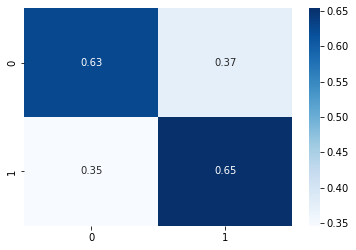

In [90]:
cf_matrix = confusion_matrix(y_data_MCI, ypred_model)
print("confusion_matrix on MCI :")
print(cf_matrix)
cf_matrix = [cf_matrix[0,:]/np.sum(cf_matrix[0,:]), cf_matrix[1,:]/np.sum(cf_matrix[1,:])]
ax = sns.heatmap(cf_matrix, annot=True, 
            fmt='.2', cmap='Blues')
plt.show()